# Exploratory Data Analysis

The IMO database tends to contain larger, more legitimate vessels. Those not listed on the vessel registry and having a high number of gap events are more suspicious. Therefore, this section investigates patterns and relationships among the vessels that _did not_ appear in the IMO database.

In this exploratory analysis I begin with combining and cleaning the datasets. I use unsupervised machine learning techniques like clustering algorithms to identify groups of vessels exhibiting similar behavior. Due to computational limitations, I focus on analyzing the patterns within the three largest clusters to see if any broader insights can be gleaned.

## Data Dictionary

| Column | Datatype | Description |
|---------------------------|----------|-------------------------------------------------------------------------------------------------------|
| mmsi | int64 | a vessel's "unique" AIS ID |
| gap_hours | float64 | length of the gap event |
| gap_distance_m | float64 | distance of the gap event in miles |
| gap_implied_speed_knots | float64 |  |
| positions_per_day | float64 |  |
| vessel_class | object | vessel geartype |
| flag | object | The state a vessel is registered or licensed under |
| off_timestamp | object | timestamp AIS was turned off |
| off_msgid | object | message ID from AIS turning off |
| off_lat | float64 | latitude when AIS turned off |
| off_lon | float64 | longitude when AIS turned off |
| off_type | object | the class of AIS device (A or B), Class A devices are more expensive, have stronger signals and broadcast more frequently |
| off_receiver_type | object | whether the AIS message was recieved by a satellite or terrestrial receiver when turned off |
| off_distance_from_shore_m | float64 | distance from shore when AIS turned off |
| on_timestamp | object | timestamp AIS was turned on |
| on_msgid | object | message ID from AIS turning on |
| on_lat | float64 | latitude when AIS turned on |
| on_lon | float64 | longitude when AIS turned on |
| on_type | object | the class of AIS device (A or B), class A devices have stronger signals and broadcast more frequently |
| on_receiver_type | object | whether the AIS message was recieved by a satellite or terrestrial receiver when turned on |
| on_distance_from_shore_m | float64 | distance from shore when AIS turned on |

## Import Packages and Data

In [141]:
# standard data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering models and visualizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [55]:
# import IMO non registered list and gap events dataset
imo_notreg = pd.read_csv('./data/imo_notreg.csv')
gap_events = pd.read_csv('./data/raw_sample.csv') 

In [56]:
# check the contents
print(f'Total Non-Registered Vessels: {len(imo_notreg)}')
print(f'Gap Events: {len(gap_events)}')

Total Non-Registered Vessels: 79066
Gap Events: 500000


In [57]:
imo_notreg['0'].nunique()

43168

In [262]:
# Confirm how often the most common MMSI number appears (to avoid skewed analysis)
imo_notreg['0'].value_counts().head()

563022450    14
431008005    13
416005616    12
228208700    12
224220130    11
Name: 0, dtype: int64

## Combine, Clean, Explore

### Combine

In [59]:
# Filter the full gap events dataset to only include the non registered vessels
gap_notreg = gap_events[gap_events['ssvid'].isin(imo_notreg['0'])]
gap_notreg.shape

(346762, 21)

In [60]:
# change ssvid column name for consistency
gap_notreg = gap_notreg.rename(columns={'ssvid':'mmsi'})

In [61]:
gap_notreg.describe()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,off_lat,off_lon,off_distance_from_shore_m,on_lat,on_lon,on_distance_from_shore_m
count,3.467620e+05,346762.000000,3.467620e+05,346762.000000,344906.000000,346762.000000,346762.000000,3.467540e+05,346762.000000,346762.000000,3.467560e+05
mean,4.134220e+08,125.473019,2.873190e+04,0.414658,11.761397,31.890658,90.835906,1.838358e+04,31.893232,90.844197,1.865638e+04
std,1.803360e+08,429.313197,1.693180e+05,3.504960,41.770756,12.703357,57.082368,7.212948e+04,12.698465,57.077196,7.240180e+04
min,1.114720e+05,12.000000,0.000000e+00,0.000000,0.000000,-89.977667,-179.833372,0.000000e+00,-89.929540,-179.909047,0.000000e+00
25%,2.774402e+08,16.733333,3.407681e+02,0.003546,0.001704,24.832000,109.011728,0.000000e+00,24.840870,109.005823,0.000000e+00
50%,4.124257e+08,30.550000,3.613040e+03,0.044143,0.051323,31.008883,119.521981,2.000000e+03,31.038048,119.530272,2.000000e+03
75%,4.160017e+08,83.016667,1.703127e+04,0.237987,1.785874,37.930020,121.949576,1.300000e+04,37.930048,121.953170,1.300000e+04
max,1.020002e+09,15511.116667,1.919246e+07,617.980208,735.613968,72.965227,179.995645,1.994000e+06,72.889147,179.999600,2.002000e+06


### Clean

In [83]:
# Check for null values
gap_notreg.isnull().sum()

mmsi                            0
gap_hours                       0
gap_distance_m                  0
gap_implied_speed_knots         0
positions_per_day            1855
vessel_class                    0
flag                            0
off_timestamp                   0
off_msgid                       0
off_lat                         0
off_lon                         0
off_type                     1855
off_receiver_type               0
off_distance_from_shore_m       8
on_timestamp                    0
on_msgid                        0
on_lat                          0
on_lon                          0
on_type                      1569
on_receiver_type                0
on_distance_from_shore_m        6
dtype: int64

In [202]:
# null vals in positions and off type are related?
# if the AIS device not known when AIS turned off, cannot record positions?
gap_notreg[(gap_notreg['positions_per_day'].isnull() == True) & (gap_notreg['off_type'].isnull() == True)]

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m,off_cluster
332,441177000,14.250000,11806.436439,0.447366,NaN,set_longlines,KOR,2019-01-17 23:58:00+00:00,e8999767-efbc-5c92-b974-d7343d7aabd6,33.275000,...,satellite,23000.0,2019-01-18 14:13:22+00:00,090ddc9c-603f-523f-b645-35bad933c342,33.230000,126.993333,NaN,satellite,18000.0,0
350,548040400,41.066667,5450.100129,0.071660,NaN,other_purse_seines,PHL,2019-04-27 19:36:35+00:00,bd7598d8-9897-5f0d-8dfc-9afba7f43f66,6.846667,...,satellite,3000.0,2019-04-29 12:41:00+00:00,820ebede-9dba-8166-dc48-f6230dec6a8e,6.892142,122.081752,A,satellite,1000.0,17
366,412331061,14.000000,350067.633318,13.501529,NaN,squid_jigger,CHN,2018-12-21 11:20:51+00:00,70785358-b0b7-58e9-89c9-9cf23425926f,22.700000,...,satellite,84000.0,2018-12-22 01:20:52+00:00,89612178-2025-540f-bba1-d7cf0577790b,20.035000,115.651667,NaN,satellite,133000.0,0
682,247200190,55.900000,106.126405,0.001025,NaN,trawlers,ITA,2019-02-15 19:47:55+00:00,a01311d7-afb3-b527-cd92-62daefbffbd8,44.308333,...,satellite,0.0,2019-02-18 03:42:22+00:00,f7a54ea0-9ca4-582f-8720-b4670d378c2a,44.309145,9.334035,A,terrestrial,0.0,1
1092,440117480,12.550000,18963.697805,0.815903,NaN,fishing,KOR,2019-11-28 20:59:23+00:00,38105fbd-0018-bbc4-b9c4-f254c670444f,35.136667,...,satellite,76000.0,2019-11-29 09:32:36+00:00,4e1c3800-5ba1-344b-35ef-4fa16bd9737f,35.306667,130.145000,NaN,satellite,68000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345868,440123480,17.433333,0.000000,0.000000,NaN,fishing,KOR,2018-12-24 04:45:05+00:00,81f4d8f7-3b48-5b18-8ae4-0a53135dc4a2,34.730000,...,satellite,1000.0,2018-12-24 22:12:01+00:00,b418cbee-1dd5-5f41-9e63-58073be19d39,34.730000,127.730000,NaN,satellite,1000.0,0
345888,227825000,79.466667,32013.546185,0.217524,NaN,trawlers,FRA,2018-10-18 01:00:32+00:00,11de69c6-e642-3b5a-b93c-90233d6a4020,50.286667,...,satellite,30000.0,2018-10-21 08:28:53+00:00,2bff4d29-5922-5922-b906-18cc9b147963,50.060452,1.379730,A,terrestrial,0.0,1
346224,211572000,21.500000,0.000000,0.000000,NaN,trawlers,DEU,2019-11-27 23:35:01+00:00,50431686-5e7a-5a35-7492-951e7661a185,54.126667,...,satellite,0.0,2019-11-28 21:05:04+00:00,4af6204e-4883-501b-adcc-74476492a931,54.126667,8.861667,NaN,satellite,0.0,1
346334,440141650,20.983333,21588.541252,0.555530,NaN,other_purse_seines,KOR,2019-12-14 00:04:03+00:00,5d566d1a-d627-fb86-599d-c80c0315b796,34.903333,...,satellite,1000.0,2019-12-14 21:04:01+00:00,c6d93488-148c-567f-b847-86f0561291e7,34.710000,128.065000,NaN,satellite,2000.0,0


In [63]:
# Check for duplicate rows
duplicates = gap_notreg.duplicated()
gap_notreg[duplicates].head()

,mmsi,gap_hours,gap_distance_m,gap_implied_speed_knots,positions_per_day,vessel_class,flag,off_timestamp,off_msgid,off_lat,...,off_type,off_receiver_type,off_distance_from_shore_m,on_timestamp,on_msgid,on_lat,on_lon,on_type,on_receiver_type,on_distance_from_shore_m
181846,367799370,68.150000,388349.446373,3.076917,NaN,fishing,USA,2019-08-21T00:48:26Z,878e6556-7c2c-13ea-421a-0000394ec61b,53.878333,...,NaN,satellite,0.0,2019-08-23T20:58:23Z,3c26a05d-d46b-194b-e03c-83688a7ec798,57.137093,-168.758933,A,satellite,75000.0
215367,251830940,62.916667,5841.122395,0.050129,110.257670,pots_and_traps,ISL,2019-08-23T13:01:06Z,b8b3da39-8310-8870-db21-633caf24635e,66.046280,...,B,satellite,1000.0,2019-08-26T03:56:11Z,c2010308-2c4c-562d-a233-024afc9f5c9a,66.066978,-17.464547,B,terrestrial,5000.0
244896,316023416,16.416667,2826.827867,0.092977,4.078816,drifting_longlines,CAN,2019-08-07T14:17:16Z,f8529f7b-f4ae-bb0c-468f-0c7eca9e986f,42.117038,...,B,satellite,144000.0,2019-08-08T06:42:20Z,7b3bb14d-bf50-6c77-795f-b7c780726404,42.097015,-66.313693,B,satellite,146000.0
250121,412440617,12.266667,94.193130,0.004146,49.255718,tuna_purse_seines,CHN,2019-06-22T12:43:42Z,3414014d-aa73-7851-b376-6730c685a696,6.076032,...,B,satellite,14000.0,2019-06-23T01:00:41Z,2cf6057b-4e26-7120-2ddb-71730387eb27,6.075303,-55.293493,B,satellite,14000.0
318469,201601321,13.316667,18897.623709,0.766250,8.355057,drifting_longlines,ALB,2019-09-13T09:16:16Z,4558b176-bfa9-3d41-28a7-ea194e17ef0f,10.044378,...,B,satellite,417000.0,2019-09-13T22:36:02Z,eab1b595-4355-8a2f-8818-9fc3327e857b,9.899655,131.547628,B,satellite,401000.0


In [64]:
# Drop duplicate rows
gap_notreg = gap_notreg.drop_duplicates()

In [193]:
gap_notreg.shape

(346750, 22)

In [65]:
# Change time columns to datetime
gap_notreg['off_timestamp'] = pd.to_datetime(gap_notreg['off_timestamp'], format='%Y-%m-%d %H:%M:%S')
gap_notreg['on_timestamp'] = pd.to_datetime(gap_notreg['on_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [66]:
# Check timeframe of datatset
gap_notreg['off_timestamp'].min(), gap_notreg['off_timestamp'].max()

(Timestamp('2018-01-01 00:05:37+0000', tz='UTC'),
 Timestamp('2019-12-31 09:48:32+0000', tz='UTC'))

### Explore

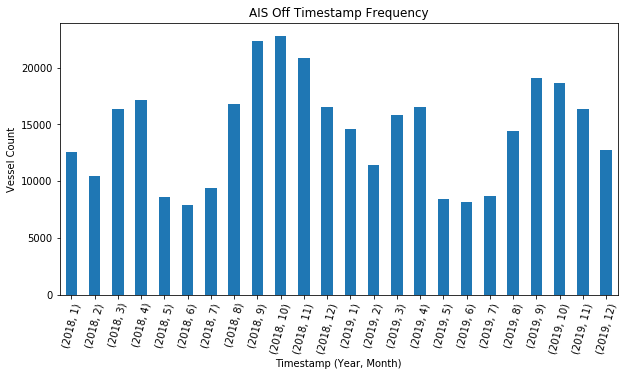

In [53]:
# Understand the distribution of AIS Off timestamps across 2-year period

plt.figure(figsize=(10,5))

# Group dataframe by month and year
timing = gap_notreg['off_timestamp'].groupby([gap_notreg['off_timestamp'].dt.year,
                                              gap_notreg['off_timestamp'].dt.month])

# Plot based on vessel count
ax = timing.count().plot(kind="bar", title="AIS Off Timestamp Frequency", rot=75)
ax.set_xlabel("Timestamp (Year, Month)")
ax.set_ylabel("Vessel Count");

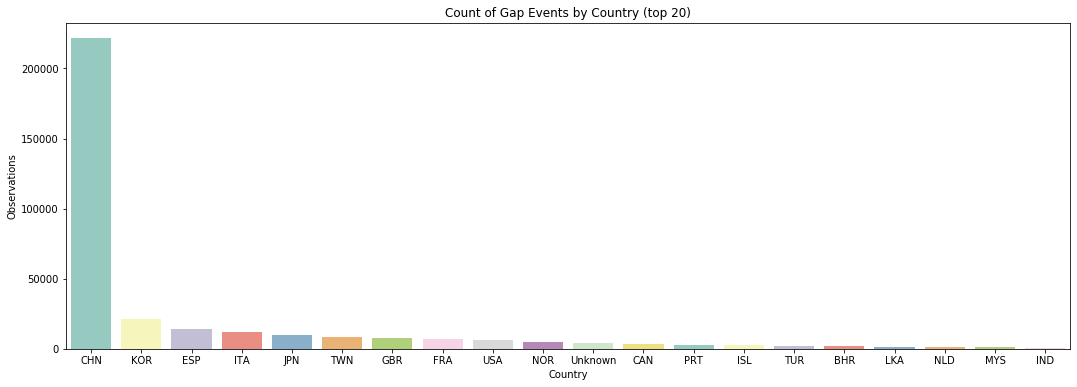

In [140]:
# Check which countries have the most gap events?

plt.figure(figsize=(18,6))
gap_by_country = sns.countplot(x="flag", data=gap_notreg, palette="Set3",
                  order=gap_notreg['flag'].value_counts().iloc[:20].index)

gap_by_country.set(xlabel='Country', 
                   ylabel='Observations', 
                   title='Count of Gap Events by Country (top 20)');   

In [275]:
# The vessels with the most observations are from which countries?
gap_notreg.groupby('flag')['mmsi'].value_counts().sort_values(ascending=False).head(10)

flag  mmsi     
GBR   235067061    54
CHN   412465495    49
KOR   440152920    48
TWN   416005071    47
FRA   227594760    47
USA   366977270    46
KOR   440004120    45
ESP   224080660    45
BGR   207822650    44
AUS   503051090    44
Name: mmsi, dtype: int64

In [97]:
# How many observations of vessels with AIS on and off timestamps at shore?

at_shore = gap_notreg.loc[(gap_notreg['on_distance_from_shore_m'] == 0.00) & (gap_notreg['off_distance_from_shore_m'] == 0.00)]

len(at_shore)

75214

# DBSCAN Model 1: Clustering Coordinates Where Vessels Go Dark

The popular clustering algorithm DBSCAN is a useful tool for exploration at this stage because it creates clusters by linking nearby data points to one another. I will use location data at the moment vessels go dark (turn off their AIS transponders) as the features.

The latitude and longitude coordinates must be [converted from degrees to radians](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) in order to use Scikit-Learn's haversine distance metric. The algorithm uses an epsilon value (distance threshold) of 20 km, which is also converted to radian units. This means that if the distance between two AIS off locations is less than 20 km, the points are considered neighbors. The min samples parameter is set at 40 as it seemed reasonable to assume that 40 instances of vessels going dark within a 20 km radius is worthy of further investigation. Scaling is not required since the data is in latitude longitude coordinates.

The models are evaluated based on their silhouette score, which quantifies the average distance between points within a cluster and the average distance between clusters. 


## Prepare Features

In [67]:
# Make a dataframe of only lat/lon at AIS switch off

latlon_off = gap_notreg[['off_lat', 'off_lon']]
latlon_on = gap_notreg[['on_lat', 'on_lon']]

latlon_off.head()

,off_lat,off_lon
0,29.940583,122.278518
1,38.099993,13.543718
2,43.406192,-8.471367
3,26.573672,120.874392
4,44.675090,12.241697


In [68]:
latlon_on.head()

,on_lat,on_lon
0,29.938277,122.273638
1,38.088952,13.540445
2,43.354105,-8.375345
3,26.564128,120.902237
4,44.675367,12.235438


In [69]:
# convert columns to numpy matrices
off_coords = latlon_off.to_numpy()
on_coords = latlon_on.to_numpy()

# check array
off_coords

array([[ 29.94058333, 122.27851833],
       [ 38.09999333,  13.54371833],
       [ 43.40619167,  -8.47136667],
       ...,
       [ 24.60301833, 119.626755  ],
       [ 38.79213667, 121.40220333],
       [ 37.69489667, 121.143345  ]])

In [70]:
# convert epsilon and coordinates to radians 
# code adapted from Geoff Boeing
kms_per_radian = 6371.0088
epsilon = 20 / kms_per_radian 

off_coords = np.radians(off_coords)
on_coords = np.radians(on_coords)

# check array
off_coords

array([[ 0.52256176,  2.13416275],
       [ 0.66497033,  0.23638248],
       [ 0.75758096, -0.14785324],
       ...,
       [ 0.42940368,  2.08788075],
       [ 0.67705051,  2.11886817],
       [ 0.65790006,  2.11435024]])

## Fit and Evaluate

In [ ]:
# instantiate and fit
dbscan = DBSCAN(eps=epsilon, min_samples= 40, algorithm='ball_tree', metric='haversine')
dbscan.fit(off_coords)

In [19]:
# check how many clusters were created
len(set(dbscan.labels_)) 

294

In [30]:
# pass in data and clusters to get the silhouette score
silhouette_score(off_coords, dbscan.labels_)

-0.30836982280981134

In [31]:
# Create cluster column
latlon_off['off_cluster'] = dbscan.labels_
latlon_off.head()

,off_lat,off_lon,off_cluster
0,29.940583,122.278518,0
1,38.099993,13.543718,1
2,43.406192,-8.471367,2
3,26.573672,120.874392,0
4,44.675090,12.241697,3


In [22]:
# Which clusters have the most observations?
latlon_off['off_cluster'].value_counts()

 0      208866
-1       29211
 11      20214
 18       6635
 10       4873
         ...  
 259        40
 292        40
 291        36
 289        34
 287        27
Name: off_cluster, Length: 294, dtype: int64

# DBSCAN Model 2: Clustering Coordinates and Length of Gap Event

Given the poor silhouette score and high number of clusters in the first model iteration, I decided to consider the length of the gap event (gap_hours) in addition to the vessel's location at the point of going dark. This time, the features were not converted to radians and the euclidean metric was used instead of haversine. Scaling was applied given the difference in units.

The different parameters that I tested and the model's performance are detailed in the [conclusions](#Conclusions) section below.

## Prepare Features

In [78]:
# 4 features were off lat off lon gap hours, gap distance
gap_notreg.columns

Index(['mmsi', 'gap_hours', 'gap_distance_m', 'gap_implied_speed_knots',
       'positions_per_day', 'vessel_class', 'flag', 'off_timestamp',
       'off_msgid', 'off_lat', 'off_lon', 'off_type', 'off_receiver_type',
       'off_distance_from_shore_m', 'on_timestamp', 'on_msgid', 'on_lat',
       'on_lon', 'on_type', 'on_receiver_type', 'on_distance_from_shore_m'],
      dtype='object')

In [103]:
# Create dataframe of only lat/lon/gap_hr data
X = gap_notreg[['off_lat', 'off_lon', 'gap_hours']]
X

,off_lat,off_lon,gap_hours
0,29.940583,122.278518,39.433333
1,38.099993,13.543718,80.800000
2,43.406192,-8.471367,15.816667
3,26.573672,120.874392,14.433333
4,44.675090,12.241697,16.450000
...,...,...,...
499994,35.452900,119.596432,36.366667
499995,34.483688,119.794732,102.416667
499996,24.603018,119.626755,42.500000
499997,38.792137,121.402203,41.100000


In [104]:
# Scale the data
ss = StandardScaler()
X_sc = ss.fit_transform(X)

## Fit and Evaluate

In [105]:
# Instantiate and fit with only scaled data
dbscan = DBSCAN(eps=.07, min_samples= 60, metric='euclidean')
dbscan.fit(X_sc)

DBSCAN(algorithm='auto', eps=0.07, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=60, n_jobs=None, p=None)

In [106]:
# check how many clusters were created
len(set(dbscan.labels_)) 

48

In [107]:
# Check the silhouette score
silhouette_score(X_sc, dbscan.labels_)

0.07654379945811801

In [110]:
# Create cluster column
X['off_cluster'] = dbscan.labels_
X.head()

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,off_lat,off_lon,gap_hours,off_cluster
0,29.940583,122.278518,39.433333,0
1,38.099993,13.543718,80.800000,1
2,43.406192,-8.471367,15.816667,1
3,26.573672,120.874392,14.433333,0
4,44.675090,12.241697,16.450000,1


In [192]:
# Which clusters have the most observations?
X['off_cluster'].value_counts().head()

 0    249260
 1     52770
-1     25429
 3      5191
 9      2147
Name: off_cluster, dtype: int64

### Conclusions

| model | eps | min_samples | distance metric | clusters | # features | silhouette score |
|-------|--------------|-------------|-----------------|----------|------------|------------------|
| 1 | 0.003 (20km) | 40 | haversine | 294 | 2 | -0.308 |
| 2 | 0.005 | 40 | euclidean | 305 | 3 | -0.4946 |
| 3 | 0.05 | 40 | euclidean | 66 | 3 | 0.0079 |
| 4 | 0.07 | 50 | euclidean | 53 | 3 | 0.1906 |
| 5 | 0.07 | 60 | euclidean | 48 | 3 | 0.0765 |
| 6 | 0.07 | 60 | euclidean | 39 | 4 | -0.2993 |


Running and scoring the DBSCAN algorithm proved to be very computationally expensive (often killing the kernal), which hindered a more robust exploration of features and parameter tuning. The 6 models were evaluated by their silhouette score, which is calculated using the average distance of points within a cluster and the average distance between clusters for each sample. Essentially, the silhouette score provides insight into the density and separation of clusters.  

Model 5 produced the highest score of 0.077, using the 'off_lat', 'off_lon', and 'gap_hours' features. It found 48 clusters, with approximately 70% of the observations in cluster 0. The results of this model are used in the next stage of exploratory analysis.

## Add Predictions to Dataset

In [113]:
# Merge cluster into the original dataframe
gap_notreg = gap_notreg.merge(X, how='outer', left_index=True, right_index=True)

# Drop the duplicate columns created in merge
gap_notreg.drop(columns=['off_lat_y', 'off_lon_y', 'gap_hours_y'], inplace=True)

In [114]:
# Rename columns
gap_notreg.rename(columns={'off_lat_x' : 'off_lat',
                           'off_lon_x' : 'off_lon',
                           'gap_hours_x' : 'gap_hours'}, inplace=True)

In [117]:
# Save updated dataframe to CSV
gap_notreg.to_csv('./data/gap_notreg_off_clusters.csv', index=False)

## Visualize Results

In [143]:
gap_notreg = pd.read_csv('./data/gap_notreg_off_clusters.csv')

In [215]:
gap_notreg.dtypes

mmsi                           int64
gap_hours                    float64
gap_distance_m               float64
gap_implied_speed_knots      float64
positions_per_day            float64
vessel_class                  object
flag                          object
off_timestamp                 object
off_msgid                     object
off_lat                      float64
off_lon                      float64
off_type                      object
off_receiver_type             object
off_distance_from_shore_m    float64
on_timestamp                  object
on_msgid                      object
on_lat                       float64
on_lon                       float64
on_type                       object
on_receiver_type              object
on_distance_from_shore_m     float64
off_cluster                    int64
dtype: object

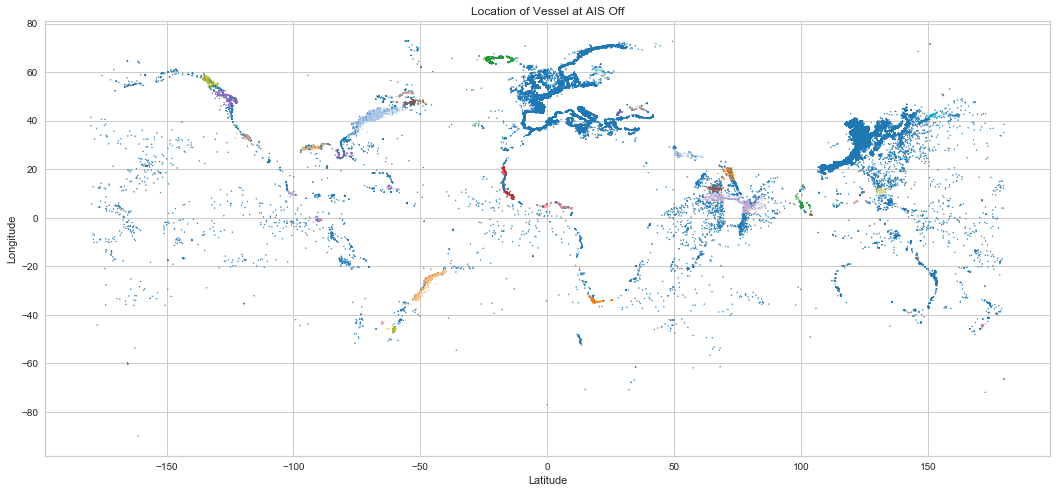

In [245]:
# Explore clusters visually
plt.figure(figsize=(18, 8))

plt.scatter(gap_notreg['off_lon'], gap_notreg['off_lat'], c=gap_notreg['off_cluster'], s=1, cmap="tab20")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Location of Vessel at AIS Off');

In [246]:
# Break top 5 clusters (including noise) into dataframes to better visualize

cluster0 = gap_notreg[gap_notreg['off_cluster'] == 0]
cluster_1 = gap_notreg[gap_notreg['off_cluster'] == -1]
cluster1 = gap_notreg[gap_notreg['off_cluster'] == 1]
cluster3 = gap_notreg[gap_notreg['off_cluster'] == 3]
cluster9 = gap_notreg[gap_notreg['off_cluster'] == 9]

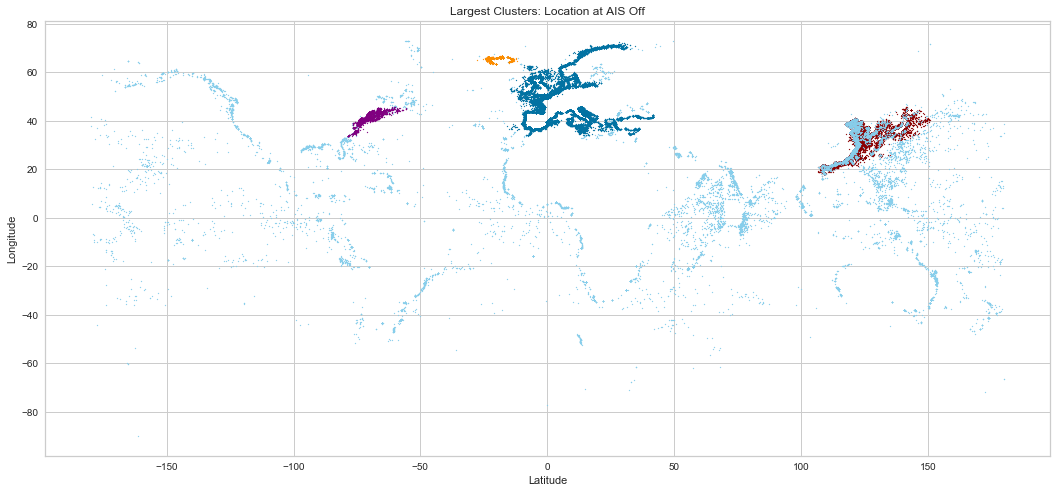

In [251]:
# Plot again to distinguish clusters from noise

plt.figure(figsize=(18, 8))

plt.scatter(cluster0['off_lon'], cluster0['off_lat'], s=1, c='darkred');
plt.scatter(cluster_1['off_lon'], cluster_1['off_lat'], s=1, c='skyblue');
plt.scatter(cluster1['off_lon'], cluster1['off_lat'], s=1, c='b')
plt.scatter(cluster3['off_lon'], cluster3['off_lat'], s=1, c='purple')
plt.scatter(cluster9['off_lon'], cluster9['off_lat'], s=1, c='darkorange')

plt.title('Largest Clusters: Location at AIS Off')
plt.xlabel('Latitude')
plt.ylabel('Longitude');

# EDA of Clusters

In [119]:
# Explore any patterns in the first few clusters
gap_notreg.groupby('off_cluster')[['gap_hours', 
                                   'gap_distance_m',
                                   'positions_per_day', 
                                   'on_distance_from_shore_m',
                                   'off_distance_from_shore_m',]].mean().T.loc[:,[0,1,3]]

off_cluster,0,1,3
gap_hours,70.194658,37.730851,39.876446
gap_distance_m,26909.085504,9047.440903,24880.254694
positions_per_day,9.275423,8.543319,12.891640
on_distance_from_shore_m,12501.039076,6453.360118,24818.146793
off_distance_from_shore_m,12095.635080,6348.520744,25225.004816


In [231]:
# Check the distribution of gap hours in each cluster
def gaphr_hist(cluster):
    fig, ax = plt.subplots(figsize=(13,2))
    sns.boxplot(x=cluster['gap_hours'], ax=ax)
    ax.set_title(f"Gap Hour Distribution")
    ax.set_xlabel('Gap Hours')
    ax.tick_params(labelsize=10);
    

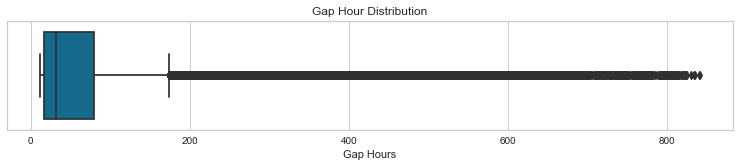

In [232]:
gaphr_hist(cluster0)

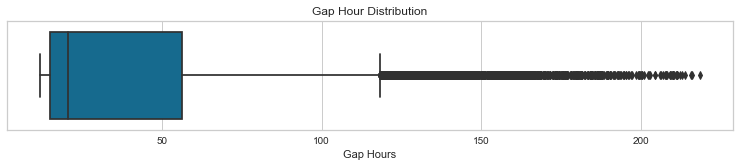

In [225]:
gaphr_hist(cluster1)

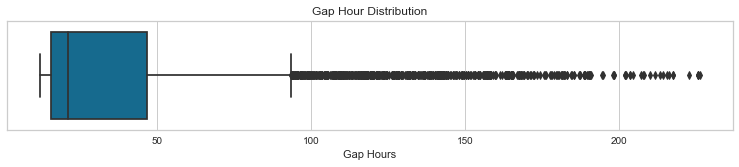

In [226]:
gaphr_hist(cluster3)

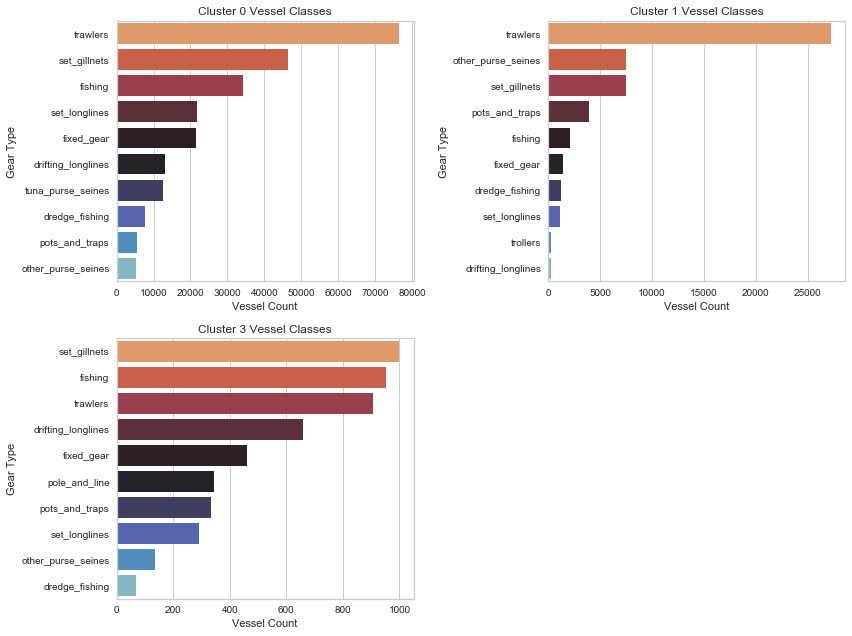

In [146]:
# Which vessel classes appear the most in each cluster and how often?

plt.figure(figsize=(12,9)) 

plt.subplot(2,2,1)
sns.countplot(y="vessel_class", 
              data=cluster0, 
              palette="icefire_r",
              order=cluster0['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 0 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.subplot(2,2,2)
sns.countplot(y="vessel_class", 
              data=cluster1, 
              palette="icefire_r",
              order=cluster1['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 1 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.subplot(2,2,3)
sns.countplot(y="vessel_class", 
              data=cluster3, 
              palette="icefire_r",
              order=cluster3['vessel_class'].value_counts().iloc[:10].index).set(title=('Cluster 3 Vessel Classes'),
                                                                                 xlabel=('Vessel Count'),
                                                                                 ylabel=('Gear Type'))
plt.tight_layout();

In [252]:
# What is the average length of gap event for the most common vessel class in each cluster?

top_vessel_gap0 = cluster0.loc[cluster0['vessel_class'] == 'trawlers']['gap_hours'].mean().round(2)
print(f'Avg Length of Gap for Trawlers in Cluster 0: {top_vessel_gap0} hours')

top_vessel_gap1 = cluster1.loc[cluster1['vessel_class'] == 'trawlers']['gap_hours'].mean().round(2)
print(f'Avg Length of Gap for Trawlers in Cluster 1: {top_vessel_gap1} hours')

top_vessel_gap3 = cluster3.loc[cluster3['vessel_class'] == 'set_gillnets']['gap_hours'].mean().round(2)
print(f'Avg Length of Gap for Set Gillnets in Cluster 3: {top_vessel_gap3} hours')

Avg Length of Gap for Trawlers in Cluster 0: 67.46 hours
Avg Length of Gap for Trawlers in Cluster 1: 40.48 hours
Avg Length of Gap for Set Gillnets in Cluster 3: 40.66 hours


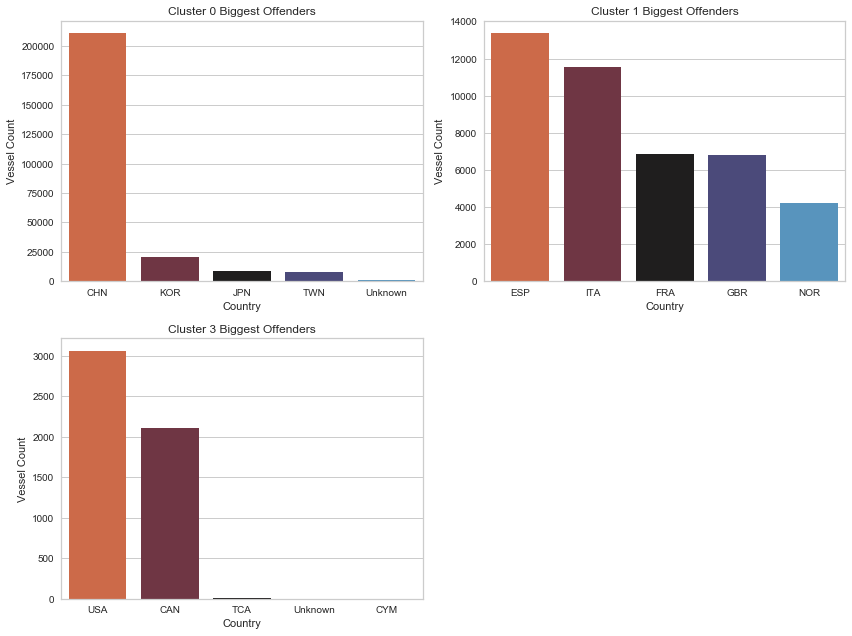

In [188]:
# Which countries are the biggest offenders in each cluster?

plt.figure(figsize=(12,9))

plt.subplot(2,2,1)
sns.countplot(x="flag", 
              data=cluster0, 
              palette="icefire_r",
              order=cluster0['flag'].value_counts().iloc[:5].index).set(title=('Cluster 0 Biggest Offenders'),
                                                                                 xlabel=('Country'),
                                                                                 ylabel=('Vessel Count'))
plt.subplot(2,2,2)
sns.countplot(x="flag", 
              data=cluster1, 
              palette="icefire_r",
              order=cluster1['flag'].value_counts().iloc[:5].index).set(title=('Cluster 1 Biggest Offenders'),
                                                                                 xlabel=('Country'),
                                                                                 ylabel=('Vessel Count'))
plt.subplot(2,2,3)
sns.countplot(x="flag", 
              data=cluster3, 
              palette="icefire_r",
              order=cluster3['flag'].value_counts().iloc[:5].index).set(title=('Cluster 3 Biggest Offenders'),
                                                                                 xlabel=('Country'),
                                                                                 ylabel=('Vessel Count'))
plt.tight_layout();

In [183]:
# Which countries have the highest average gaps
#cluster0.groupby('flag')[['gap_hours']].mean().sort_values(by='gap_hours', ascending=False)

In [178]:
# Which vessels have the highest num of gap hours and where are they from?
cluster0.groupby(['mmsi','vessel_class'])[['gap_hours']].sum().sort_values(by='gap_hours', ascending=False)

,,gap_hours
mmsi,vessel_class,
333300571,fixed_gear,2915.016667
412268359,drifting_longlines,2850.316667
416211900,set_longlines,2810.316667
416001516,set_longlines,2809.050000
412413185,fixed_gear,2789.433333
...,...,...
412378069,trawlers,12.050000
412888774,tuna_purse_seines,12.016667
413238388,set_gillnets,12.016667


In [263]:
top3 = gap_notreg.loc[(gap_notreg['off_cluster'] == 0) | (gap_notreg['off_cluster'] == 1)| (gap_notreg['off_cluster'] == 3)]

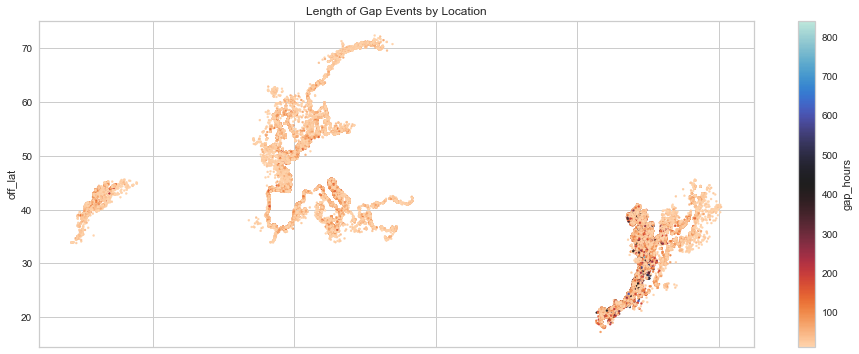

In [265]:
top3.plot(kind="scatter", 
                  x="off_lon",
                  y="off_lat", 
                  c="gap_hours",
                  cmap="icefire_r", 
                  figsize=(16, 6), 
                  s=4, 
                  title='Length of Gap Events by Location');

In [258]:
# Are there any relationships between location and the length of the gap event?
# Since the avg gap hours for each cluster is between 30-70, analyze gaps less than 1000 hrs

def gaps_scatter(cluster):
    low_gaps = cluster[cluster['gap_hours'] < 1000]
    return low_gaps.plot(kind="scatter", 
                  x="off_lon",
                  y="off_lat", 
                  c="gap_hours",
                  cmap="icefire_r", 
                  figsize=(16, 8), 
                  s=4, 
                  title='Length of Gap Events by Location')

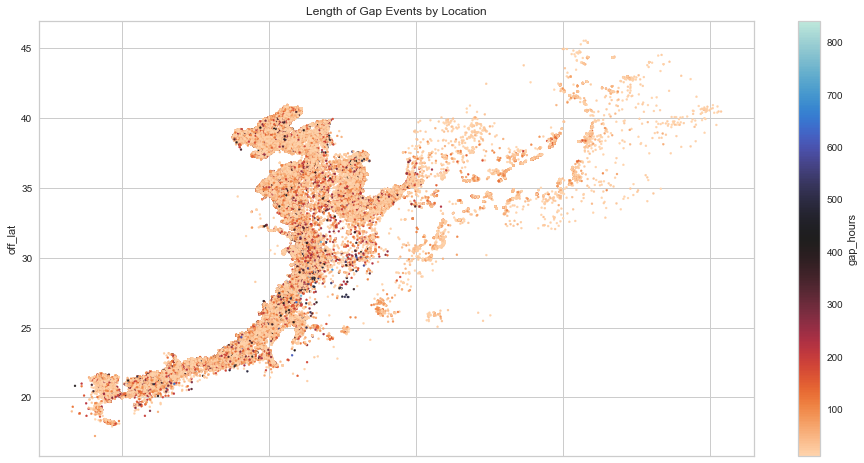

In [259]:
gaps_scatter(cluster0);

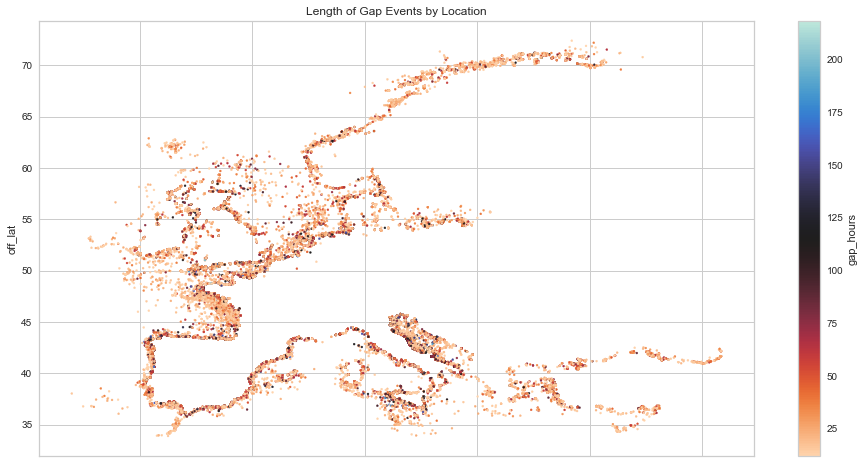

In [260]:
gaps_scatter(cluster1);

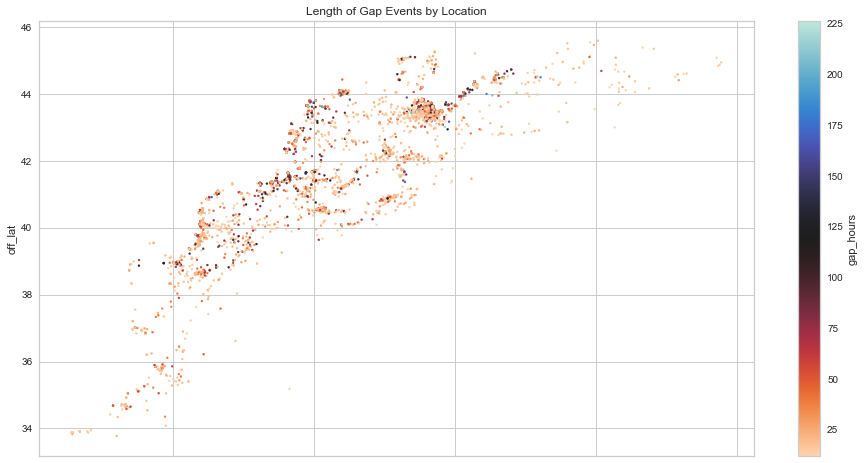

In [261]:
gaps_scatter(cluster3);

In [216]:
# When are the gap events taking place in each cluster?
# plt.figure(figsize=(10,5))

# # Group dataframe by month and year
# cluster0_time = cluster0['off_timestamp'].groupby([cluster0['off_timestamp'].dt.year,
#                                                    cluster0['off_timestamp'].dt.month])

# # Plot based on vessel count
# ax = cluster0_time.count().plot(kind="bar", title="Cluster 0 Off Timestamps", rot=75)
# ax.set_xlabel("Timestamp (Year, Month)")
# ax.set_ylabel("Vessel Count");

In [217]:
# Create plots for each cluster to analyze going dark timestamp


# Conclusions
Overall, the gap events dataset indicates a disproportionately large number of observations from China. Other highly represented countries include South Korea, Spain, Italy, Japan and Taiwan. It's important to take note of the vessels that appear multiple times. A single vessel from Great Britain appeared 54 times, followed by one from China that appeared 49 times and one from South Korea that appeared 48 times. Since the dataset I'm working with is a random sampling of MMSI numbers from a much larger dataset, these findings should be considered a starting point for deeper investigation. 

Visualizing when vessels are going dark over the two year timeframe indicates some seasonality: a high number of vessels are turning off AIS between the months of August - December. Smaller peaks can be seen from March - April and then the numbers drop in the early summer months.

### Cluster 0 
- Largest cluster in dataset, comprising approximately 70% of the observations
- Average length of gap events in this cluster is 70 hours. 75% of the events last under 200 hrs (8 days) but there are many outliers including gap events as long as 800 hrs (1 month).  
- Trawling is the most widespread activity.
- Trawlers and set gillnets together comprise 50% of the activity seen in this cluster.
- The average length of a gap event for vessels using trawlers is lower than the cluster's average.

### Cluster 1 
-  Comprises approximately 15% of the observations in the dataset.
- The spread/distribution in length of gap events is much smaller than cluster 0 and the average length is around 38 hours. 
- This is interesting given trawling is also the most popular activity, but the average length of a gap event for vessels using trawlers is more aligned with the cluster's average.
- The average distance of a gap event is the smallest in this cluster, as well as the average number of positions each day.


### Cluster 3
- Third largest cluster in the dataset after the unassigned data points classified as noise (cluster -1). 
- The average length of gap events is 39 hrs, which is higher than in cluster 1, but shows a smaller spread given the smaller number of observations.
- The average gap distance is quite large and on par with the average in cluster 0.
- Set gillnets, fishing and trawlers are equally widespread activities in this area. They show average gap event lengths between 36-41 hours, consistent with the overall average.

# References
- https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates
- https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
- https://link.springer.com/chapter/10.1007/978-3-030-38081-6_2